<a href="https://colab.research.google.com/github/danzgaming21/G1401221059_Muhammad-Abdan-Rofi/blob/main/HKI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# === 1) Load file Excel ===
#Upload file di Google Colab ===
from google.colab import files
uploaded = files.upload()

Saving Data Company .xlsx to Data Company .xlsx


In [2]:
# =========================
# 0) Setup & import
# =========================
import pandas as pd
import numpy as np
import re

# (Opsional) upload file di Colab:
# from google.colab import files
# uploaded = files.upload()

# Ganti sesuai nama file saat diupload ke Colab
FILE_PATH = "Data Company .xlsx"     # perhatikan spasi pada nama file jika ada
SHEETS = ['HK ', 'HKI', 'WIKA', 'PP']  # 'HK ' ada spasi di belakang

# =========================
# 1) Helper functions
# =========================
def to_num(x):
    """
    Konversi string angka Indonesia/format persen menjadi float:
    '9,19' -> 9.19 ; '0,25 %' -> 0.25 ; '12%' -> 12.0 ; angka biasa -> float
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(",", ".")
    m = re.findall(r"[-+]?\d*\.?\d+", s)
    if not m:
        return pd.to_numeric(x, errors="coerce")
    return float(m[0])

def detect_recap_row(df, labels):
    """
    Cari baris label rekap (baris yang berisi beberapa label target sekaligus).
    Mengembalikan index baris label. Minimal 3 label cocok agar dianggap rekap.
    """
    best_idx, best_hits = None, 0
    for i in range(len(df)):
        hits = 0
        for cell in df.iloc[i].astype(str).tolist():
            t = cell.lower()
            if any(lbl.lower() in t for lbl in labels):
                hits += 1
        if hits > best_hits:
            best_hits, best_idx = hits, i
    return best_idx if best_hits >= 3 else None

def read_recap(df):
    """
    Ambil pasangan LABEL->NILAI dari blok rekap 2 baris (baris label + baris nilai).
    Tidak menghitung ulang; hanya baca nilai dari Excel.
    """
    target_labels = [
        "Jumlah Followers","Jumlah Like","Jumlah Komen","Jumlah Views",
        "ER Followers Total","ER Followers per Post",
        "Followers Awal","Followers Akhir","Followers Growth","Jumlah Post"
    ]
    ridx = detect_recap_row(df, target_labels)
    if ridx is None or ridx + 1 >= len(df):
        return {}
    labels = df.iloc[ridx].fillna("")
    values = df.iloc[ridx + 1]
    recap = {}
    for j in range(len(labels)):
        key = str(labels.iloc[j]).strip()
        if key:
            recap[key] = values.iloc[j]
    return recap

def get_value(recap, key_contains):
    """Ambil nilai dari dict recap dengan pencarian 'contains' (tahan variasi ejaan/spasi)."""
    for k, v in recap.items():
        if key_contains.lower() in str(k).lower():
            return to_num(v)
    return np.nan

def find_col(df, candidates):
    """Cari kolom dengan nama alternatif (case-insensitive)."""
    norm = {c.casefold().strip(): c for c in df.columns}
    for cand in candidates:
        k = cand.casefold().strip()
        if k in norm:
            return norm[k]
    return None

# =========================
# 2) Ekstraksi per sheet (tanpa hitung ulang)
# =========================
rows = []
for sheet in SHEETS:
    raw = pd.read_excel(FILE_PATH, sheet_name=sheet)
    df = raw.copy()
    df.columns = df.columns.str.strip()

    # Baca rekap langsung dari Excel
    recap = read_recap(df)
    total_post_recap   = get_value(recap, "Jumlah Post")
    followers_recap    = get_value(recap, "Jumlah Followers")
    er_total_recap     = get_value(recap, "ER Followers Total")
    er_by_post_recap   = get_value(recap, "ER Followers per Post")
    growth_recap       = get_value(recap, "Followers Growth")

    # Cadence: kalau ingin murni dari Excel juga (tanpa hitung), cukup tambahkan label di rekap.
    # Di sini, kalau tidak ada di rekap, kita hitung dari rentang tanggal sebagai fallback.
    col_date = find_col(df, ["tanggal","date","time","timestamp"])
    if pd.notna(total_post_recap):
        total_post = int(total_post_recap)
    else:
        if col_date is not None:
            df[col_date] = pd.to_datetime(df[col_date], errors="coerce")
            total_post = int(df[col_date].notna().sum())
        else:
            total_post = 0

    if col_date is not None and total_post > 1:
        data_rows = df[pd.to_datetime(df[col_date], errors="coerce").notna()]
        weeks = (data_rows[col_date].max() - data_rows[col_date].min()).days / 7
        cadence = total_post / weeks if weeks > 0 else float(total_post)
    else:
        cadence = float(total_post)

    rows.append({
        "Company": str(sheet).strip(),
        "Total Posting": int(total_post),
        "Cadence (post/minggu)": round(float(cadence), 2),
        "ER Followers Total (%)": er_total_recap,
        "ER Followers by Post (%)": er_by_post_recap,
        "Total Followers": int(followers_recap) if pd.notna(followers_recap) else np.nan,
        "Followers Growth (%)": growth_recap,
    })

df_metrics = pd.DataFrame(rows)

# Tampilkan hasil (jika ingin format rapi)
df_metrics
# Atau simpan ke CSV:
# df_metrics.to_csv("metrics_ringkas.csv", index=False)


,Company,Total Posting,Cadence (post/minggu),ER Followers Total (%),ER Followers by Post (%),Total Followers,Followers Growth (%)
0,HK,19,3.09,13.530172,0.712114,232000,1.568178
1,HKI,9,1.62,16.046083,1.782898,21700,1.734646
2,WIKA,33,5.25,8.978476,0.272075,342263,0.141612
3,PP,45,7.16,9.190199,0.204227,264880,0.250551


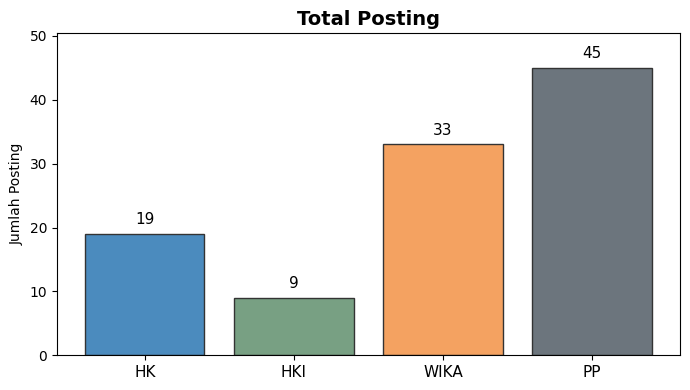

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data sumber ---
df_plot = df_metrics.copy()  # ganti sesuai nama dataframe kamu

# --- Warna elegan ---
color_map = {
    "HK":   "#4B8BBE",  # Blue Elegan
    "HKI":  "#78A083",  # Sage Green
    "WIKA": "#F4A261",  # Warm Orange
    "PP":   "#6C757D",  # Neutral Gray
}

# Warna sesuai urutan company di dataframe
colors = [color_map[c] for c in df_plot["Company"]]

# --- Plot ---
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(len(df_plot)), df_plot["Total Posting"],
               color=colors, edgecolor="#333", linewidth=1)

plt.title("Total Posting", fontsize=14, fontweight="bold")
plt.ylabel("Jumlah Posting")
plt.xticks(np.arange(len(df_plot)), df_plot["Company"], fontsize=11)

# Label angka di atas bar
ymax = max(df_plot["Total Posting"]) * 1.12
plt.ylim(0, ymax)
for b, v in zip(bars, df_plot["Total Posting"]):
    plt.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{int(v)}",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


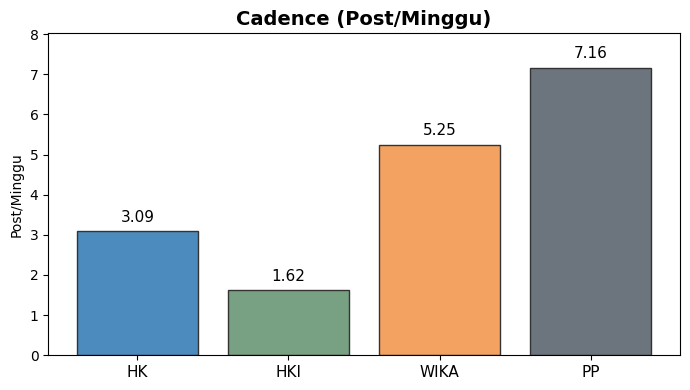

In [8]:
# --- Plot Cadence ---
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(len(df_plot)), df_plot["Cadence (post/minggu)"],
               color=colors, edgecolor="#333", linewidth=1)

plt.title("Cadence (Post/Minggu)", fontsize=14, fontweight="bold")
plt.ylabel("Post/Minggu")
plt.xticks(np.arange(len(df_plot)), df_plot["Company"], fontsize=11)

# Label angka di atas bar
ymax = max(df_plot["Cadence (post/minggu)"]) * 1.12
plt.ylim(0, ymax)
for b, v in zip(bars, df_plot["Cadence (post/minggu)"]):
    plt.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{v:.2f}",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


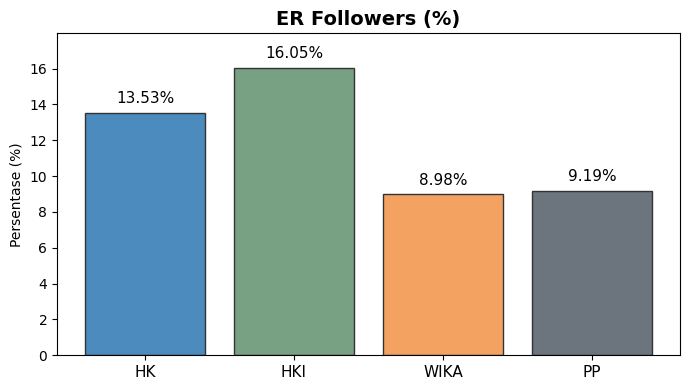

In [11]:
# --- Plot ER Followers ---
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(len(df_plot)), df_plot["ER Followers Total (%)"],
               color=colors, edgecolor="#333", linewidth=1)

plt.title("ER Followers (%)", fontsize=14, fontweight="bold")
plt.ylabel("Persentase (%)")
plt.xticks(np.arange(len(df_plot)), df_plot["Company"], fontsize=11)

# Label angka di atas bar
ymax = max(df_plot["ER Followers Total (%)"]) * 1.12
plt.ylim(0, ymax)
for b, v in zip(bars, df_plot["ER Followers Total (%)"]):
    plt.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{v:.2f}%",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

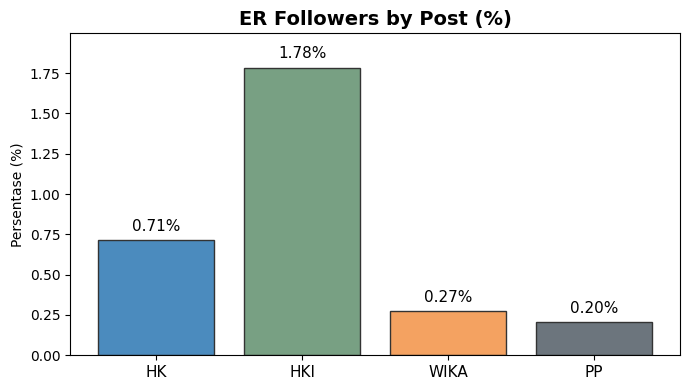

In [13]:
# --- Plot ER Followers by Post ---
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(len(df_plot)), df_plot["ER Followers by Post (%)"],
               color=colors, edgecolor="#333", linewidth=1)

plt.title("ER Followers by Post (%)", fontsize=14, fontweight="bold")
plt.ylabel("Persentase (%)")
plt.xticks(np.arange(len(df_plot)), df_plot["Company"], fontsize=11)

# Label angka di atas bar
ymax = max(df_plot["ER Followers by Post (%)"]) * 1.12
plt.ylim(0, ymax)
for b, v in zip(bars, df_plot["ER Followers by Post (%)"]):
    plt.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{v:.2f}%",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

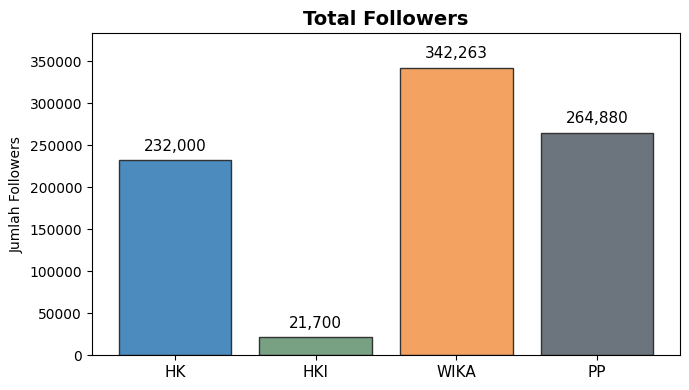

In [15]:
# --- Plot Total Followers ---
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(len(df_plot)), df_plot["Total Followers"],
               color=colors, edgecolor="#333", linewidth=1)

plt.title("Total Followers", fontsize=14, fontweight="bold")
plt.ylabel("Jumlah Followers")
plt.xticks(np.arange(len(df_plot)), df_plot["Company"], fontsize=11)

# Label angka di atas bar
ymax = max(df_plot["Total Followers"]) * 1.12
plt.ylim(0, ymax)
for b, v in zip(bars, df_plot["Total Followers"]):
    plt.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{int(v):,}",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

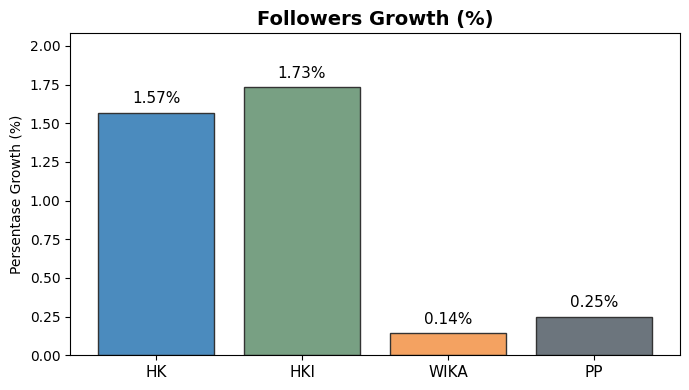

In [17]:
# --- Plot Followers Growth ---
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(len(df_plot)), df_plot["Followers Growth (%)"],
               color=colors, edgecolor="#333", linewidth=1)

plt.title("Followers Growth (%)", fontsize=14, fontweight="bold")
plt.ylabel("Persentase Growth (%)")
plt.xticks(np.arange(len(df_plot)), df_plot["Company"], fontsize=11)

# Label angka di atas bar
ymax = max(df_plot["Followers Growth (%)"]) * 1.2
plt.ylim(0, ymax)
for b, v in zip(bars, df_plot["Followers Growth (%)"]):
    plt.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{v:.2f}%",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

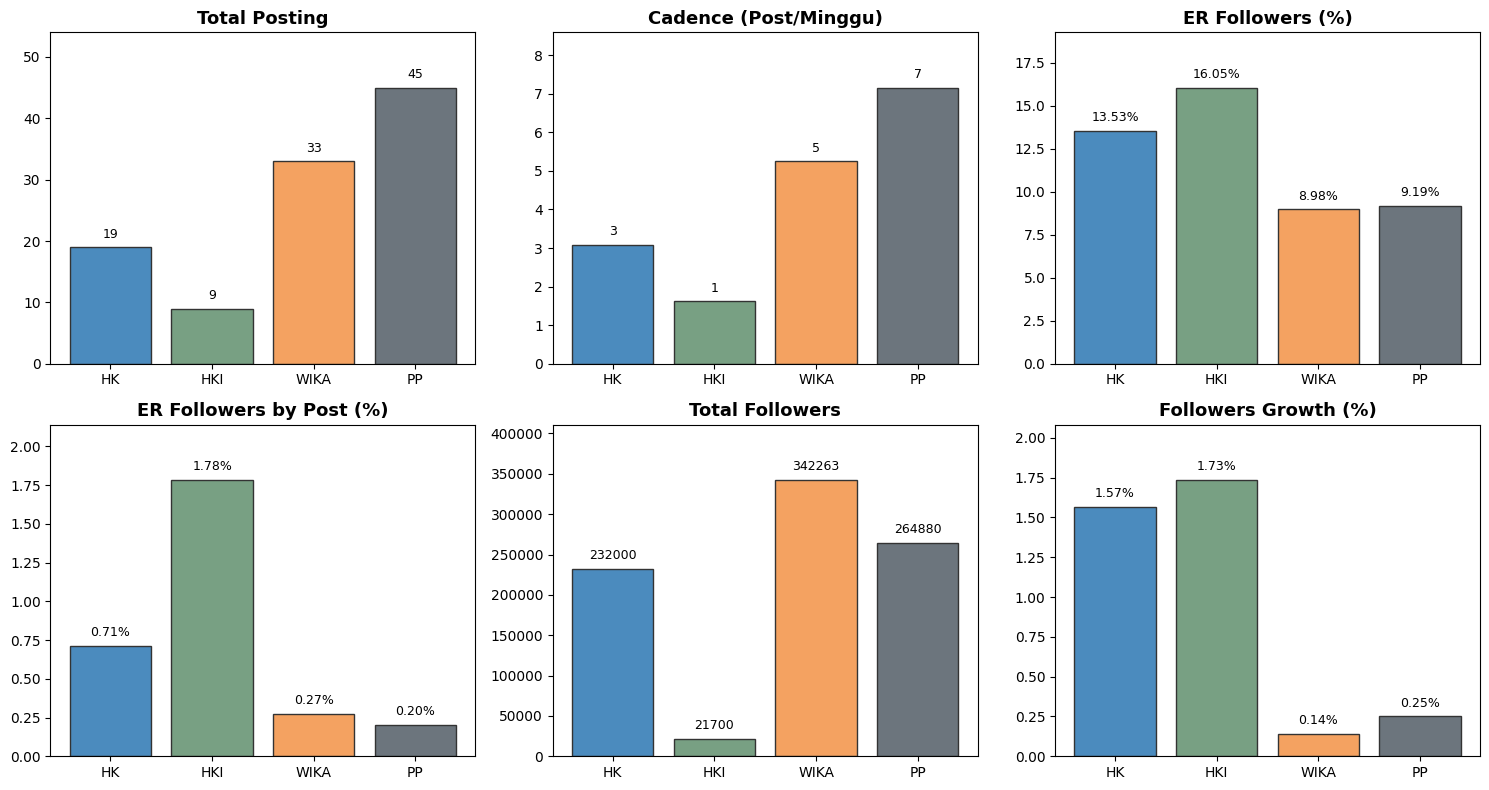

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

titles = [
    "Total Posting",
    "Cadence (Post/Minggu)",
    "ER Followers (%)",
    "ER Followers by Post (%)",
    "Total Followers",
    "Followers Growth (%)"
]

data_cols = [
    "Total Posting",
    "Cadence (post/minggu)",
    "ER Followers Total (%)",
    "ER Followers by Post (%)",
    "Total Followers",
    "Followers Growth (%)"
]

for i, ax in enumerate(axes):
    col = data_cols[i]
    bars = ax.bar(np.arange(len(df_plot)), df_plot[col],
                  color=colors, edgecolor="#333", linewidth=1)

    ax.set_title(titles[i], fontsize=13, fontweight="bold")
    ax.set_xticks(np.arange(len(df_plot)))
    ax.set_xticklabels(df_plot["Company"], fontsize=10)

    ymax = max(df_plot[col]) * 1.2
    ax.set_ylim(0, ymax)

    for b, v in zip(bars, df_plot[col]):
        if "ER" in col or "Growth" in col:
            ax.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{v:.2f}%",
                    ha="center", va="bottom", fontsize=9)
        else:
            ax.text(b.get_x() + b.get_width()/2, v + (ymax*0.02), f"{int(v)}",
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()